Basic Usage, ZebraFish Haemoglobin protein
======================


## ``Gromacs_py`` basic example

Here is an example of a short simulation of the Zebrafish Haemoglobin protein
Five successive steps are used:

1. Topology creation using ``GmxSys.add_top()``.
2. Minimisation of the structure using ``GmxSys.em_2_steps()``.
3. Solvation of the system using ``GmxSys.solvate_add_ions()``.
4. Equilibration of the system using ``GmxSys.em_equi_three_step_iter_error()``.
5. Production run using ``GmxSys.production()``.

### Import

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

- To use `gromacs_py` in a project:

In [2]:
from gromacs_py import gmx

## Simulation setup

- Define a few variables for you simulation, like:
    - simulation output folders
    - ionic concentration
    - number of minimisation steps
    - equilibration and production time


In [10]:
DATA_OUT = 'data_sim'

# System Setup
vsite='none'
ion_C = 0.15
sys_top_folder = os.path.join(DATA_OUT, 'sys_top')
ignore_hydrogen = {'ignh': None}

# Energy Minimisation
em_folder = os.path.join(DATA_OUT, 'em')
em_sys_folder = os.path.join(DATA_OUT, 'sys_em')
em_step_number = 5000

# Equillibration
equi_folder = os.path.join(DATA_OUT, 'sys_equi')
HA_time = 0.5
CA_time = 1.0
CA_LOW_time = 2.0

dt_HA = 0.001
dt = 0.002

HA_step = 1000 * HA_time / dt_HA
CA_step = 1000 * CA_time / dt
CA_LOW_step = 1000 * CA_LOW_time / dt

# Production
os.makedirs(DATA_OUT, exist_ok = True)
prod_folder = os.path.join(DATA_OUT, 'sys_prod')
prod_time = 10.0

prod_step = 1000 * prod_time / dt

FileNotFoundError: [Errno 2] No such file or directory: 'data_sim'

## PDB file on disk

In [4]:
pdb_file = "ZEB_HB_Refined.pdb"
sys_name = "zeb_hb"

### Create the `GmxSys` object

In [9]:
md_sys = gmx.GmxSys(name=sys_name, coor_file=pdb_file)

#Parallelization
nthreads = 4

#Set Parallelization and GPU
md_sys.nt = nthreads
md_sys.ntmpi = 1
#md_sys.gpu_id = 0
md_sys.display()

OSError: File cound not be founded :ZEB_HB_Refined.pdb

## Create topology:

Topology creation involves:
- topology creation using `pdb2gmx`
- box creation using `editconf`

**Note:** Hydrogen atoms need to be ignored, or else this won'AssertionErrort work with this particular pdb

In [6]:
md_sys.add_top(out_folder=DATA_OUT, name=sys_name, pdb2gmx_option_dict=ignore_hydrogen)
md_sys.create_box(dist=1.0, box_type="dodecahedron", check_file_out=True)

gmx pdb2gmx -f ../ZEB_HB_Refined.pdb -o zeb_hb_pdb2gmx.pdb -p zeb_hb_pdb2gmx.top -i zeb_hb_posre.itp -water tip3p -ff charmm36-jul2017 -ignh
gmx editconf -f data_sim/zeb_hb_pdb2gmx.pdb -o data_sim/zeb_hb_pdb2gmx_box.pdb -bt dodecahedron -d 1.0


## Solvation (water and $Na^{+} Cl^{-}$)

In [7]:
#solvate and add ions
md_sys.solvate_add_ions(out_folder=DATA_OUT, name=sys_name, ion_C=0.15, box_dist=1.0)

gmx editconf -f data_sim/zeb_hb_pdb2gmx_box.pdb -o data_sim/zeb_hb_pdb2gmx_box_box.pdb -bt dodecahedron -d 1.0
gmx grompp -f ../../../../../../usr/local/miniforge3/envs/mdanalysis/lib/python3.12/site-packages/gromacs_py/gmx/template/mini.mdp -c zeb_hb_water.pdb -r zeb_hb_water.pdb -p zeb_hb_water_ion.top -po out_mini.mdp -o genion_zeb_hb_water_ion.tpr -maxwarn 1
gmx genion -s genion_zeb_hb_water_ion.tpr -p zeb_hb_water_ion.top -o zeb_hb_water_ion.gro -np 17 -pname NA -nn 18 -nname CL


## Energy minimisation

In [8]:
md_sys.em_2_steps(out_folder=em_folder,
                  no_constr_nsteps=em_step_number,
                  constr_nsteps=em_step_number,
                  posres="",
                  create_box_flag=False,
                  emtol=0.1, nstxout=100)

WARNING !!! ADDING unusual parameter : "emtol"in the mdp file Init_em_zeb_hb.mdp


gmx grompp -f Init_em_zeb_hb.mdp -c ../zeb_hb_water_ion.gro -r ../zeb_hb_water_ion.gro -p ../zeb_hb_water_ion.top -po out_Init_em_zeb_hb.mdp -o Init_em_zeb_hb.tpr -maxwarn 1


ValueError: no path specified

## Plot energy:

In [8]:
ener_pd_1 = md_sys.sys_history[-1].get_ener(selection_list=['Potential'])
ener_pd_2 = md_sys.get_ener(selection_list=['Potential'])

ener_pd_1['label'] = 'no bond constr'
ener_pd_2['label'] = 'bond constr'

ener_pd = pd.concat([ener_pd_1, ener_pd_2])

ener_pd['Time (ps)'] = np.arange(len(ener_pd))

gmx energy -f data_sim/em/Init_em_zeb_hb.edr -o tmp_edr.xvg
gmx energy -f data_sim/em/zeb_hb.edr -o tmp_edr.xvg


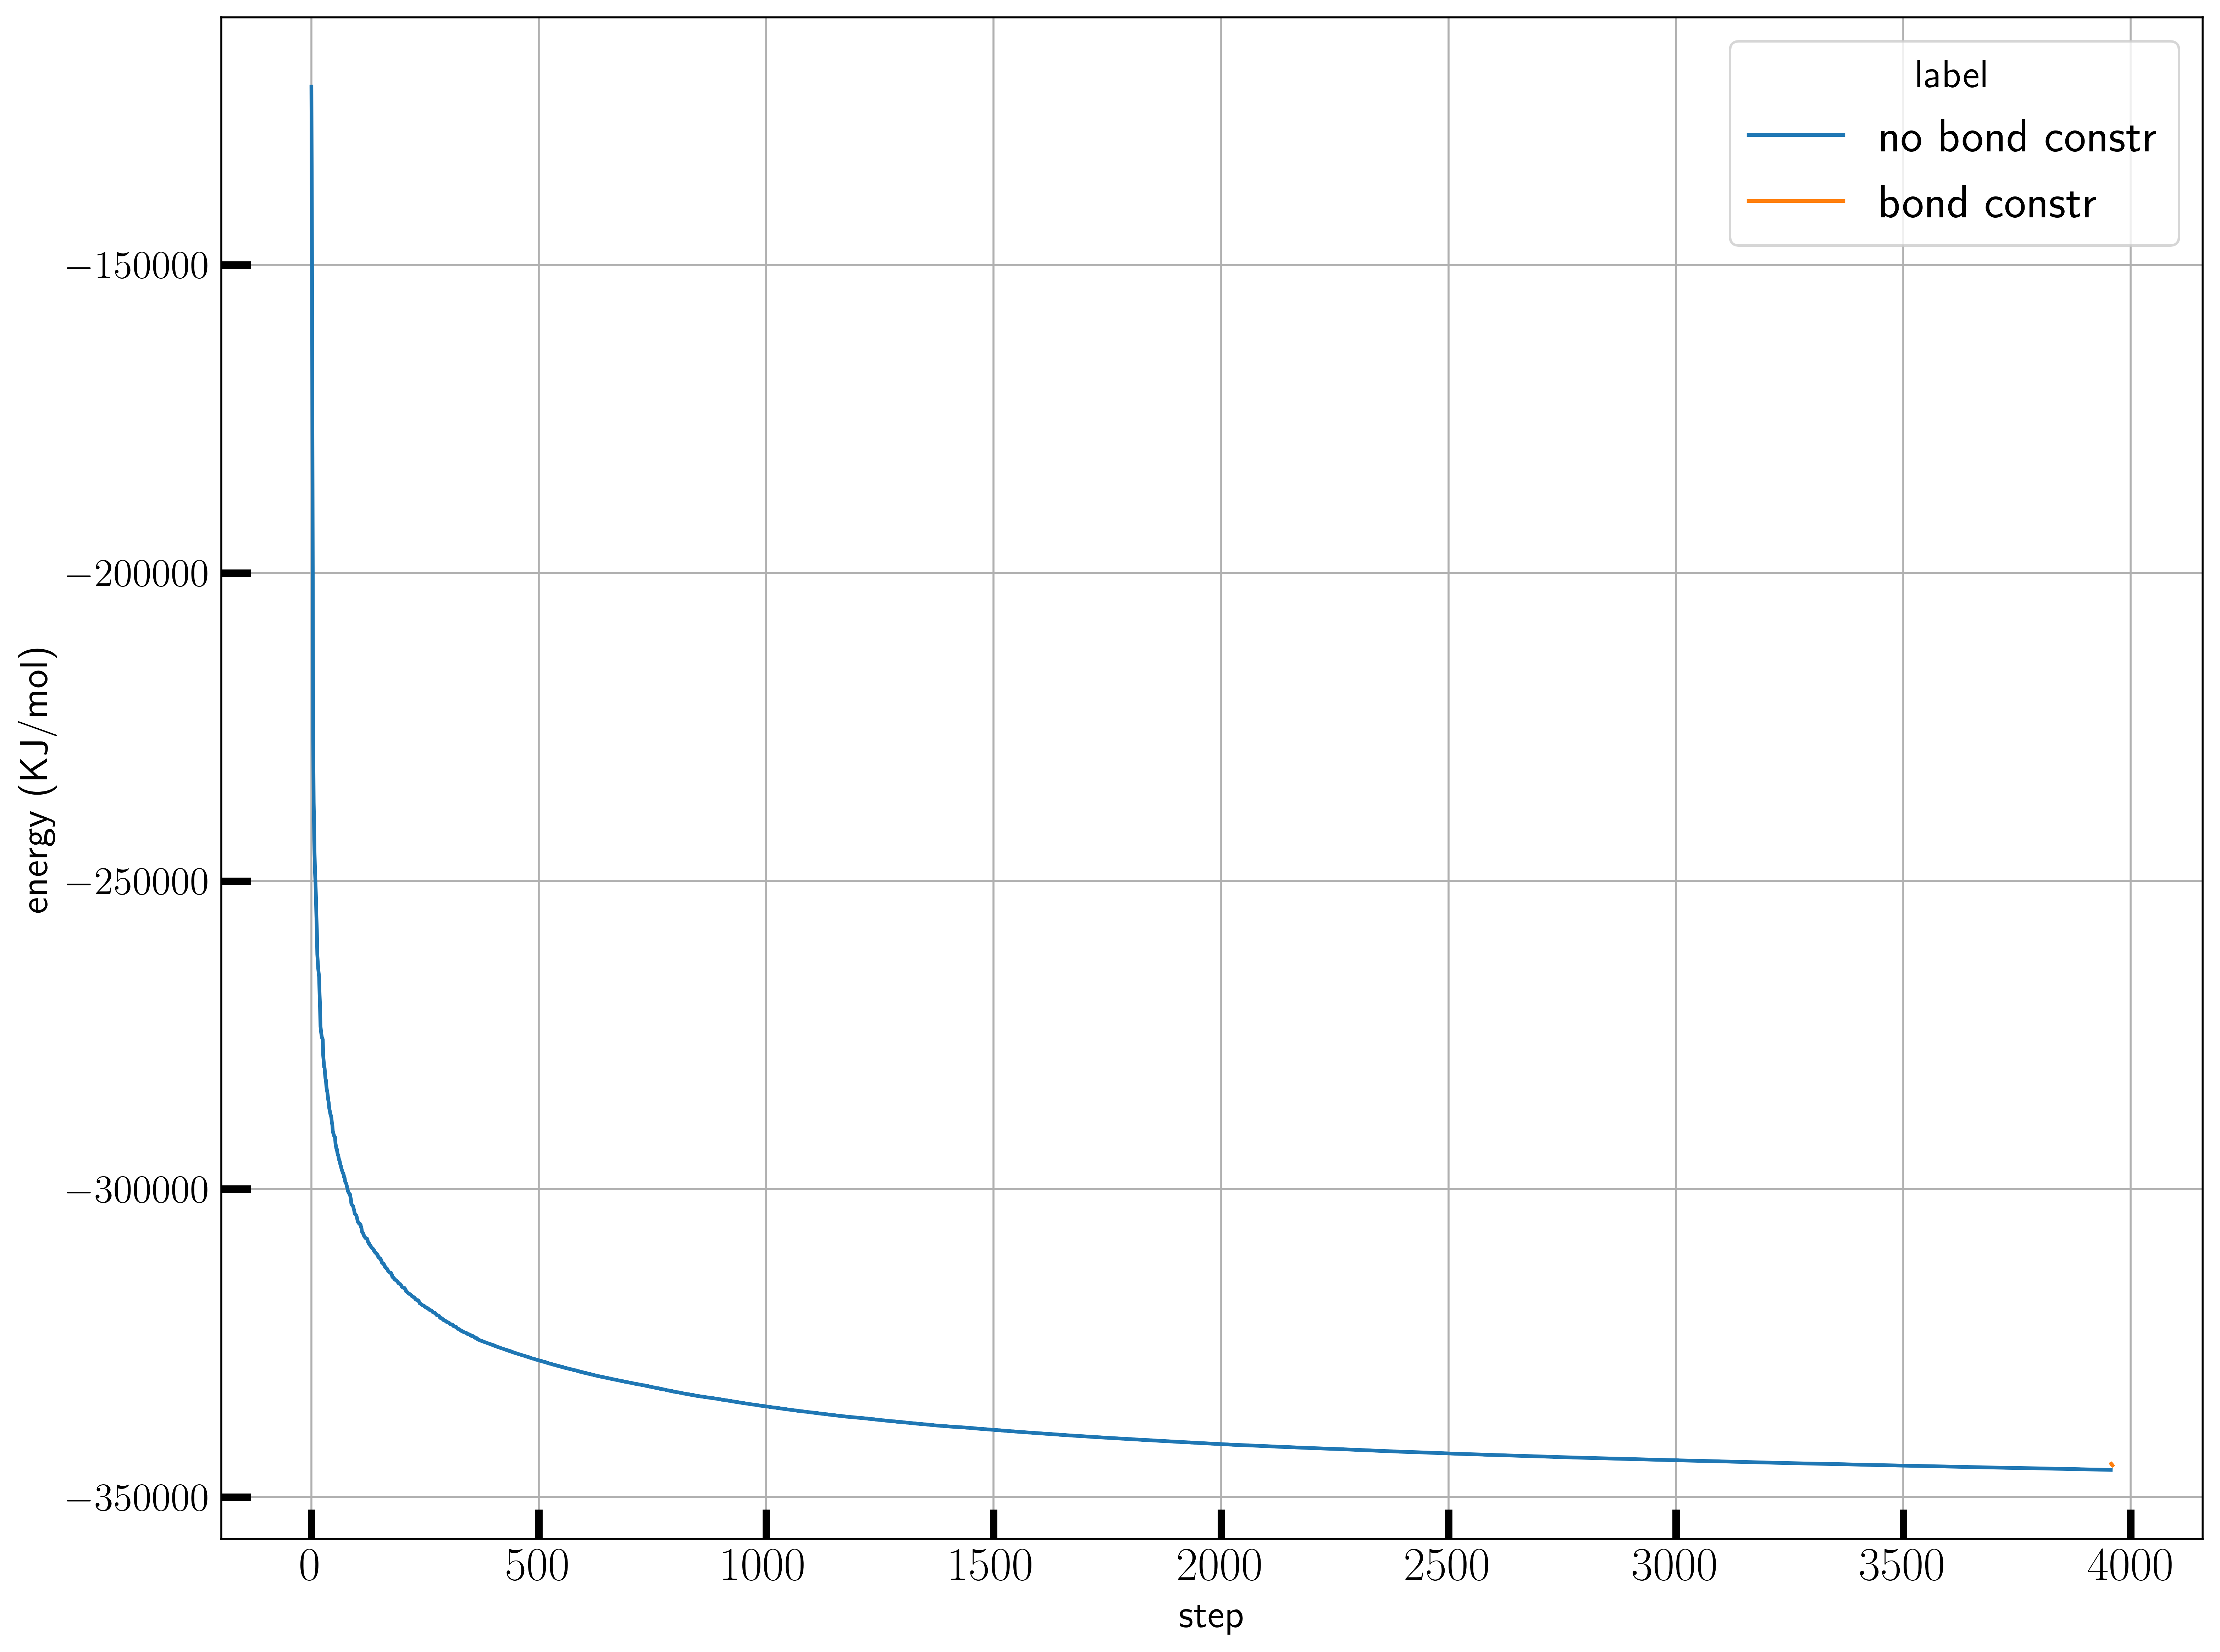

In [13]:
ax = sns.lineplot(x="Time (ps)", y="Potential",
                  hue="label",
                  data=ener_pd)
ax.set_xlabel('step')
ax.set_ylabel('energy (KJ/mol)')
plt.grid()

## System minimisation and equilibration

TODO

In [15]:
#md_sys.em_equi_three_step_iter_error(out_folder=equi_folder,
# no_constr_nsteps=em_step_number,
# constr_nsteps=em_step_number,
# nsteps_HA=HA_step,
# nsteps_CA=CA_step,
# nsteps_CA_LOW=CA_LOW_step,
# dt=dt, dt_HA=dt_HA,
# vsite=vsite, maxwarn=1)


### Plot temperature

In [35]:
ener_pd_1 = md_sys.sys_history[-2].get_ener(selection_list=['Volume'])
ener_pd_2 = md_sys.sys_history[-1].get_ener(selection_list=['Volume'])
ener_pd_3 = md_sys.get_ener(selection_list=['Volume'])

ener_pd_1['label'] = 'HA_constr'
ener_pd_2['label'] = 'CA_constr'
ener_pd_2['Time (ps)'] = ener_pd_2['Time (ps)'] + ener_pd_1['Time (ps)'].max()
ener_pd_3['label'] = 'CA_LOW_constr'
ener_pd_3['Time (ps)'] = ener_pd_3['Time (ps)'] + ener_pd_2['Time (ps)'].max()

ener_pd = pd.concat([ener_pd_1, ener_pd_2, ener_pd_3])



gmx energy -f data_sim/sys_equi/sys_equi/00_equi_HA/equi_HA_1Y0M.edr -o tmp_edr.xvg
gmx energy -f data_sim/sys_equi/sys_equi/01_equi_CA/equi_CA_1Y0M.edr -o tmp_edr.xvg
gmx energy -f data_sim/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_1Y0M.edr -o tmp_edr.xvg


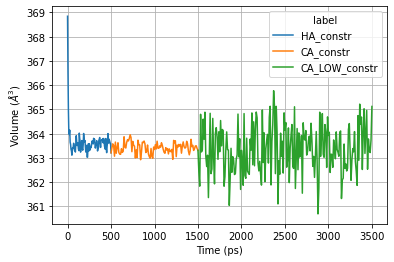

In [36]:
ax = sns.lineplot(x="Time (ps)", y="Volume",
                  hue="label",
                  data=ener_pd)

ax.set_ylabel('Volume ($Å^3$)')
plt.grid()

### Plot RMSD

In [42]:
# Define reference structure for RMSD calculation
ref_sys =  md_sys.sys_history[1]

rmsd_pd_1 = md_sys.sys_history[-2].get_rmsd(['C-alpha', 'Protein'], ref_sys=ref_sys)
rmsd_pd_2 = md_sys.sys_history[-1].get_rmsd(['C-alpha', 'Protein'], ref_sys=ref_sys)
rmsd_pd_3 = md_sys.get_rmsd(['C-alpha', 'Protein'], ref_sys=ref_sys)


rmsd_pd_1['label'] = 'HA_constr'
rmsd_pd_2['label'] = 'CA_constr'
rmsd_pd_2['time'] = rmsd_pd_2['time'] + rmsd_pd_1['time'].max()
rmsd_pd_3['label'] = 'CA_LOW_constr'
rmsd_pd_3['time'] = rmsd_pd_3['time'] + rmsd_pd_2['time'].max()

rmsd_pd = pd.concat([rmsd_pd_1, rmsd_pd_2, rmsd_pd_3])


gmx rms -s data_sim/em/Init_em_1Y0M.tpr -f data_sim/sys_equi/sys_equi/00_equi_HA/equi_HA_1Y0M.xtc -n data_sim/sys_equi/sys_equi/00_equi_HA/equi_HA_1Y0M.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no
gmx rms -s data_sim/em/Init_em_1Y0M.tpr -f data_sim/sys_equi/sys_equi/01_equi_CA/equi_CA_1Y0M.xtc -n data_sim/sys_equi/sys_equi/01_equi_CA/equi_CA_1Y0M.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no
gmx rms -s data_sim/em/Init_em_1Y0M.tpr -f data_sim/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_1Y0M.xtc -n data_sim/sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_1Y0M.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no


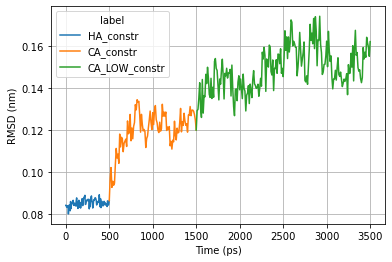

In [43]:
ax = sns.lineplot(x="time", y="Protein",
                  hue="label",
                  data=rmsd_pd)

ax.set_ylabel('RMSD (nm)')
ax.set_xlabel('Time (ps)')
plt.grid()

## Production

In [27]:
md_sys.production(out_folder=prod_folder,
                  nsteps=prod_step,
                  dt=dt, vsite=vsite, maxwarn=1)


gmx grompp -f prod_1Y0M.mdp -c ../sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_1Y0M.gro -r ../sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_1Y0M.gro -p ../sys_top/1Y0M_water_ion.top -po out_prod_1Y0M.mdp -o prod_1Y0M.tpr -maxwarn 1 -n ../sys_equi/sys_equi/02_equi_CA_LOW/equi_CA_LOW_1Y0M.ndx
gmx mdrun -s prod_1Y0M.tpr -deffnm prod_1Y0M -nt 0 -ntmpi 0 -nsteps -2 -nocopyright


  0%|          | 0/5000000 [00:00<?, ?it/s]

## Prepare trajectory

In [40]:
# Center trajectory
md_sys.center_mol_box(traj=True)

gmx make_ndx -f data_sim/sys_prod/prod_1Y0M.gro -o data_sim/sys_prod/prod_1Y0M.ndx
gmx trjconv -f data_sim/sys_prod/prod_1Y0M.xtc -o data_sim/sys_prod/prod_1Y0M_compact.xtc -s data_sim/sys_prod/prod_1Y0M.tpr -ur tric -pbc mol -center yes -n data_sim/sys_prod/prod_1Y0M.ndx


## Basic Analysis

In [44]:
rmsd_prod_pd = md_sys.get_rmsd(['C-alpha', 'Protein'], ref_sys=ref_sys)
rmsd_prod_pd['label'] = 'Production'

rmsd_prod_pd['time'] = rmsd_prod_pd['time'] + rmsd_pd['time'].max()
rmsd_all_pd = pd.concat([rmsd_pd, rmsd_prod_pd])

gmx rms -s data_sim/em/Init_em_1Y0M.tpr -f data_sim/sys_prod/prod_1Y0M_compact.xtc -n data_sim/sys_prod/prod_1Y0M.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no


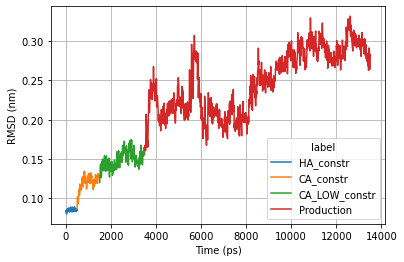

In [48]:
ax = sns.lineplot(x="time", y="Protein",
                  hue="label",
                  data=rmsd_all_pd)
ax.set_ylabel('RMSD (nm)')
ax.set_xlabel('Time (ps)')
plt.grid()

## Trajectory vizualisation

In [58]:
# Align the protein coordinates
md_sys.convert_trj(select='Protein\nSystem\n', fit='rot+trans', pbc='none', skip='10')

gmx trjconv -f data_sim/sys_prod/prod_1Y0M_compact_compact.xtc -o data_sim/sys_prod/prod_1Y0M_compact_compact_compact.xtc -s data_sim/sys_prod/prod_1Y0M.tpr -ur compact -pbc none -fit rot+trans -n data_sim/sys_prod/prod_1Y0M.ndx -skip 10


In [70]:
view = md_sys.view_traj()
view.add_representation(repr_type='licorice', selection='protein')
view.center(selection='CA')
view

NGLWidget(max_frame=100)

In [78]:
# To hide this cell add the following info in the cell metadata:
# "nbsphinx": "hidden"
import nglview as nv
nv.write_html('../_static/1Y0M_prod_traj.html', [view], frame_range=(0, 100))
from IPython.display import IFrame

In [4]:
# Unecessary, only need to nglview online:
IFrame(src='../_static/1Y0M_prod_traj.html', width=800, height=300)